# Project Report 2
## EM 212: Applied Data Science
## Alexander Christenson

The goal of this assignment is to some exploratory data analysis, data cleaning, and merging a dataset.

First I'm going to import the libraries we will use in our analysis and store our dataset as a pandas dataframe.

The datasets I will be using are:

A repository of all exchanges on bitcoin - including p2p trading volume - [DataHub.io](https://datahub.io/cryptocurrency/bitcoin).

[Gemini.com](https://gemini.com/), a bitcoin exchange listing the price of bitcoin in one minute increments from October 2015 through April 2019.

My goal for this early data analysis is to better understand the Gemini dataset, and I will combine it with the DataHub data of all the bitcoin transactions.

In [1]:
# Importing libraries from the EDA example
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
# Pulling the dataset for bitcoin prices
BTC_trans = pd.read_csv("https://datahub.io/cryptocurrency/bitcoin/r/bitcoin.csv")

In [3]:
# Importing the data from exchange
import Project_Data
bitcoin_price_2015 = pd.read_csv("Project_Data/gemini_BTCUSD_2015_1min.csv",skiprows=1)
bitcoin_price_2016 = pd.read_csv("Project_Data/gemini_BTCUSD_2016_1min.csv",skiprows=1)
bitcoin_price_2017 = pd.read_csv("Project_Data/gemini_BTCUSD_2017_1min.csv",skiprows=1)
bitcoin_price_2018 = pd.read_csv("Project_Data/gemini_BTCUSD_2018_1min.csv",skiprows=1)
bitcoin_price_2019 = pd.read_csv("Project_Data/gemini_BTCUSD_2019_1min.csv",skiprows=1)

In [4]:
# Concatonate the yearly data together
BTC_price = [bitcoin_price_2019,bitcoin_price_2018,bitcoin_price_2017,bitcoin_price_2016,bitcoin_price_2015]
BTC_price = pd.concat(BTC_price).reset_index(drop=True)

Let's examine the dataframe a little.

In [5]:
BTC_price.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1555545780000,2019-04-18 00:03:00,BTCUSD,5229.40,5229.40,5229.40,5229.40,0.000000
1,1555545720000,2019-04-18 00:02:00,BTCUSD,5230.47,5230.47,5229.40,5229.40,2.202891
2,1555545660000,2019-04-18 00:01:00,BTCUSD,5245.00,5245.00,5230.47,5230.47,0.232941
3,1555545600000,2019-04-18 00:00:00,BTCUSD,5246.10,5246.10,5229.74,5245.00,50.168412
4,1555545540000,2019-04-17 23:59:00,BTCUSD,5231.69,5246.10,5231.69,5246.10,20.000000


Get some more info on the dataframe.

In [6]:
BTC_price.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06
mean,2.577871e+11,3.753850e+03,3.755548e+03,3.752100e+03,3.753854e+03,2.950303e+00
std,5.744834e+11,3.759127e+03,3.762015e+03,3.756117e+03,3.759126e+03,2.347867e+01
min,1.444312e+09,0.000000e+00,2.425000e+02,0.000000e+00,2.360000e+02,0.000000e+00
25%,1.471493e+09,6.179800e+02,6.179800e+02,6.179800e+02,6.179800e+02,0.000000e+00
50%,1.498675e+09,2.550130e+03,2.550440e+03,2.550000e+03,2.550130e+03,1.203491e-02
75%,1.525856e+09,6.407780e+03,6.408540e+03,6.406760e+03,6.407780e+03,1.138193e+00
max,1.555546e+12,1.999900e+04,1.999900e+04,1.999070e+04,1.999900e+04,8.264463e+03


Lets check how much of each of the columns is NaN.

In [7]:
bitcoin_NaN_ratio = BTC_price.isnull().sum()/len(BTC_price)
bitcoin_NaN_ratio

Unix Timestamp    0.0
Date              0.0
Symbol            0.0
Open              0.0
High              0.0
Low               0.0
Close             0.0
Volume            0.0
dtype: float64

Looks like we're not missing any values in our dataset.

Lets see how much data we're working with.

In [8]:
print(len(BTC_price))

1812109


That's a lot of data.

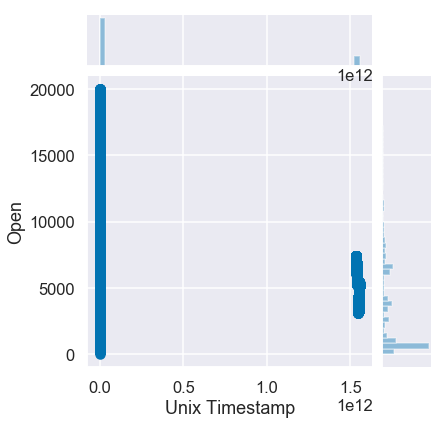

In [9]:
sns.jointplot(x=BTC_price['Unix Timestamp'],y=BTC_price['Open'])

This doesn't look quite right. Lets take a look at the distribution of the timestamps and see if something is wrong with the data.

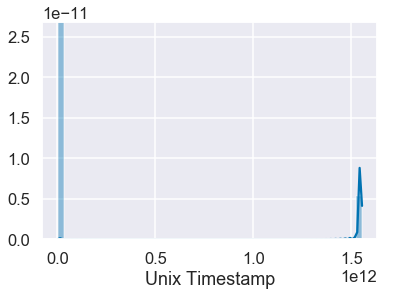

In [10]:
sns.distplot(BTC_price["Unix Timestamp"])

Hmmmmm this look like there is a massive skew in the data for the timestamps. Lets investigate this further.

In [11]:
left_data = BTC_price[BTC_price["Unix Timestamp"]<0.2e+12]
print(len(left_data))

1511299


In [12]:
right_data = BTC_price[BTC_price["Unix Timestamp"]>1.2e+12]
print(len(right_data))

300810


In [13]:
print(len(BTC_price)-len(left_data)-len(right_data))

0


Ok. It seems that literally all of the data for the timestamps is separated into two separate sections.

Let's break this down a little further.

In [14]:
from datetime import datetime # Import the libraries to convert UNIX to readable time
ts_left = int(left_data['Unix Timestamp'].iloc[0])
print(datetime.utcfromtimestamp(ts_left).strftime('%Y-%m-%d %H:%M:%S'))

2018-08-23 01:58:00


In [15]:
#ts_right = int(right_data['Unix Timestamp'].iloc[0])
#print(datetime.utcfromtimestamp(ts_right).strftime('%Y-%m-%d %H:%M:%S'))

Ah hah! This data appears to be false. Lets see how much of the data has a timestamp in this range.

In [16]:
print(right_data['Unix Timestamp'].iloc[0])
print(left_data['Unix Timestamp'].iloc[0])

1555545780000
1534989480


It looks like the left side of the data is a factor of 1000 off from the data on the right. Since the data is so tightly clustered to these regions, lets try fixing the points that are so far off by scaling the greater ones since they translate to times that are in the future.

It looks like for the years 2018 and 2019 the unix timestamps are off by a factor of 1000 based off of the differences between the previous years. Lets fix this earlier in the code and see how it affects our results.

In [17]:
BTC_price['Unix Timestamp'][BTC_price['Unix Timestamp']>1e+12] = BTC_price['Unix Timestamp'][BTC_price['Unix Timestamp']>1e+12]/1000

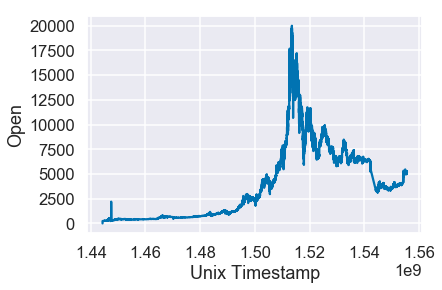

In [18]:
sns.lineplot(x=BTC_price['Unix Timestamp'],y=BTC_price['Open'])
sns.set(rc={'figure.figsize':(30,10)})

Now this data looks like it's following a more realistic trend. Lets compare this chart to existing charts, like this one from CoinMarketCap:
![alt text](Project_Data/chart.png "Logo Title Text 1")

The portion of the chart we need to pay attention to is the one highlighted with blue below.

The CoinMarketCap graph is made from data taken every day, compared to our data which is collected every minute, and comes from its own exchange. This exchange could have been manipulated by large transaction volumes after it recently opened or have seen spikes in demand at a particular minute, or could have been errors in the data. Let's zoom in a little on this section.

In [19]:
# This process is very inefficient, taking a long time for my computer to process,
# and is unecessary to building a model to give us insights about the data.
# For these reasons I am commenting out this section.
#def convertToHuman(a):
#    return datetime.utcfromtimestamp(a).strftime('%Y-%m-%d %H:%M:%S')
#
#BTC_price['Human Timestamp'] = BTC_price['Unix Timestamp'].apply(convertToHuman)
#sns.lineplot(x=BTC_price['Human Timestamp'],y=BTC_price['Open'])

In [20]:
subset = BTC_price[(BTC_price['Unix Timestamp']<1.448e+9)&(BTC_price['Unix Timestamp']>1.447e+9)]

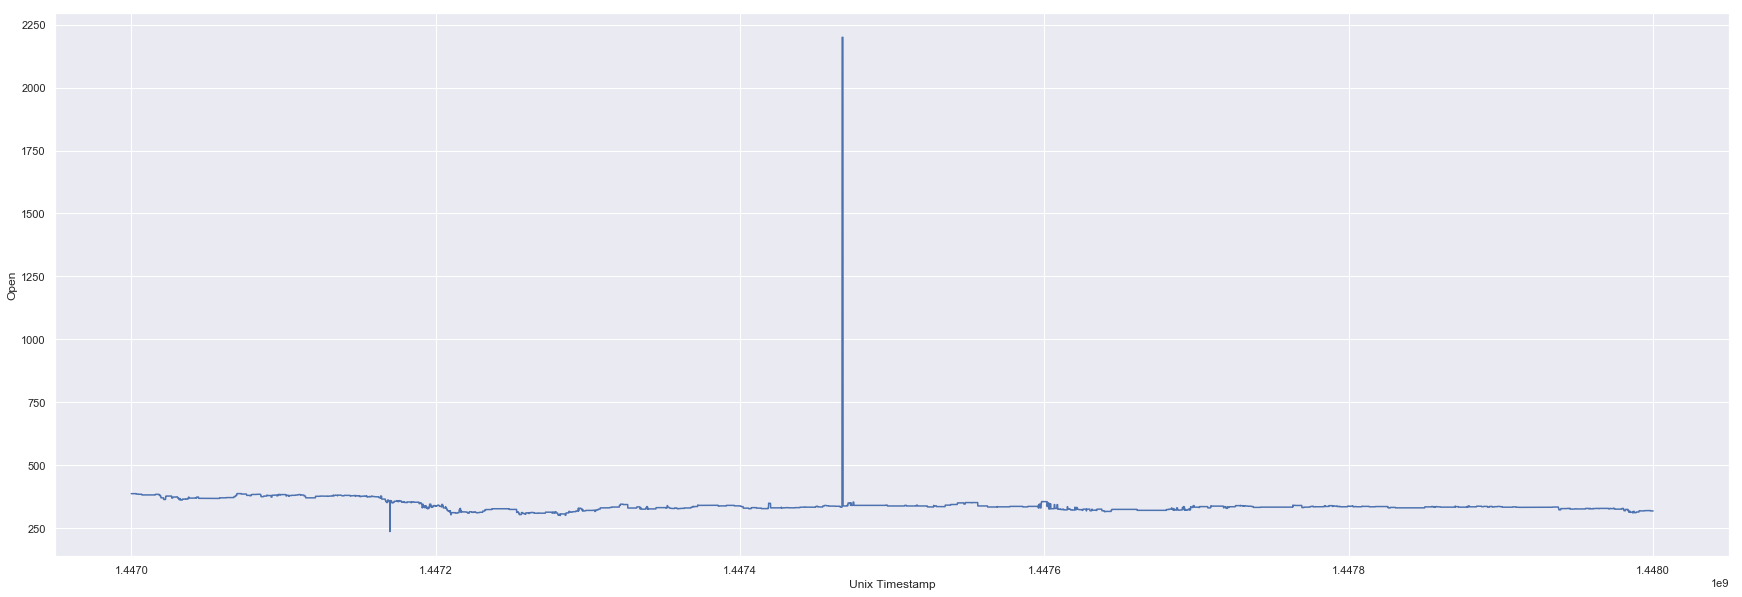

In [21]:
sns.lineplot(x=subset['Unix Timestamp'],y=subset['Open'])

There's definitely a spike in value here. Let's see how long it lasts.

In [22]:
spike = subset[subset['Open']>500]

In [23]:
len(spike)

10

Since the data is in minutes, and the length is ten, this means the spike only lasted for 10 minutes. Let's do a log transformation on the data before smoothing it.

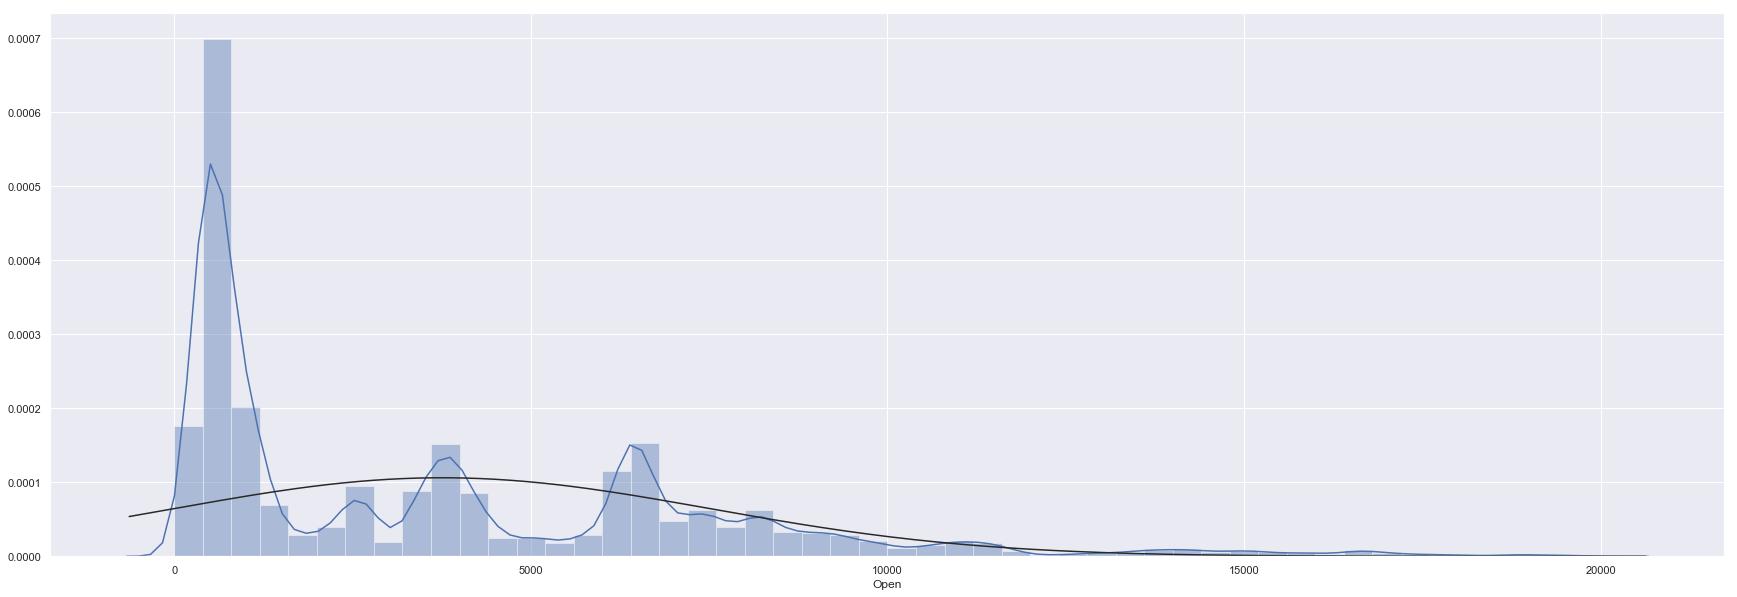

In [24]:
sns.distplot(BTC_price['Open'], fit=stats.norm)

This data looks like it's pretty spread apart in magnitude. Lets take a look at the Q-Q plot.

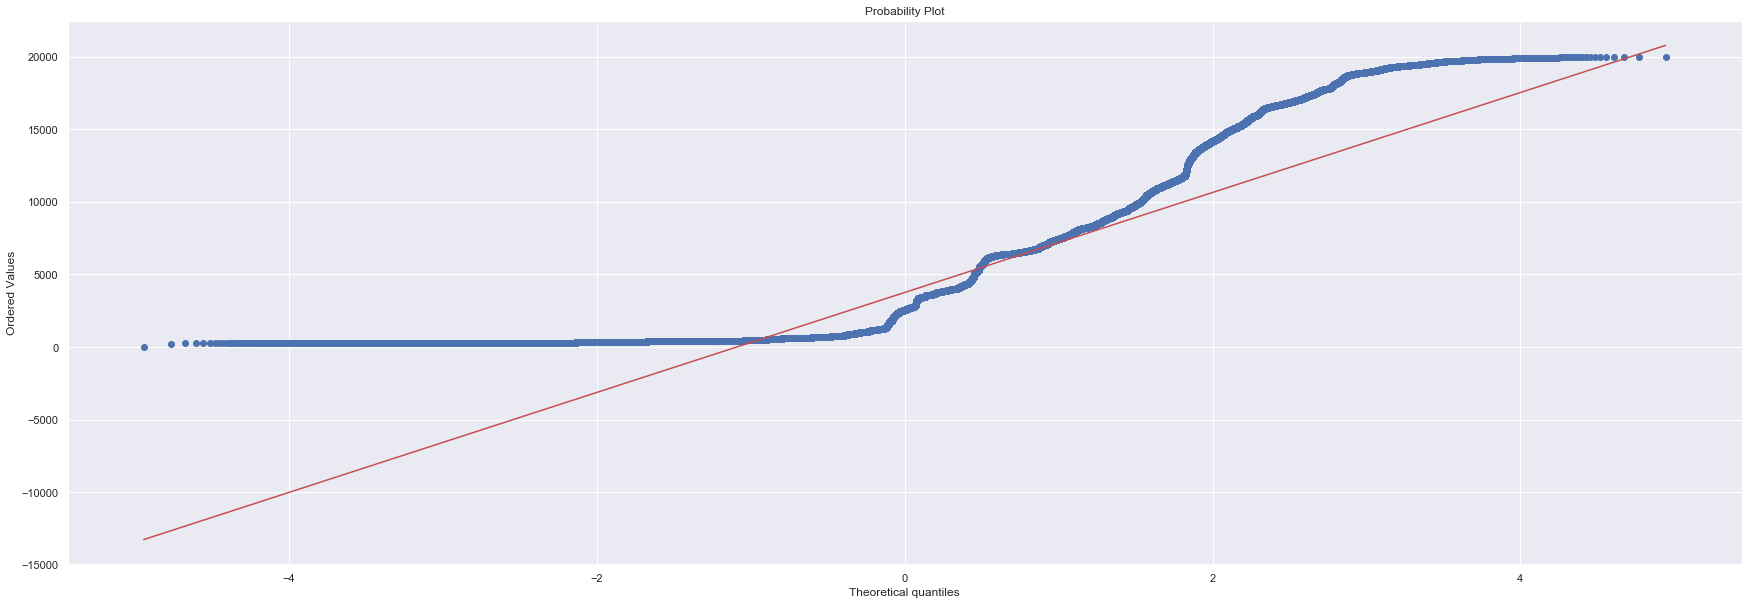

In [25]:
res = stats.probplot(BTC_price['Open'], plot=plt)
plt.show()

Let's do a log transformation to smooth this out a bit.

In [26]:
BTC_price['Open'] = np.log1p(BTC_price['Open'])
BTC_price['Close'] = np.log1p(BTC_price['Close'])
BTC_price['High'] = np.log1p(BTC_price['High'])
BTC_price['Low'] = np.log1p(BTC_price['Low'])

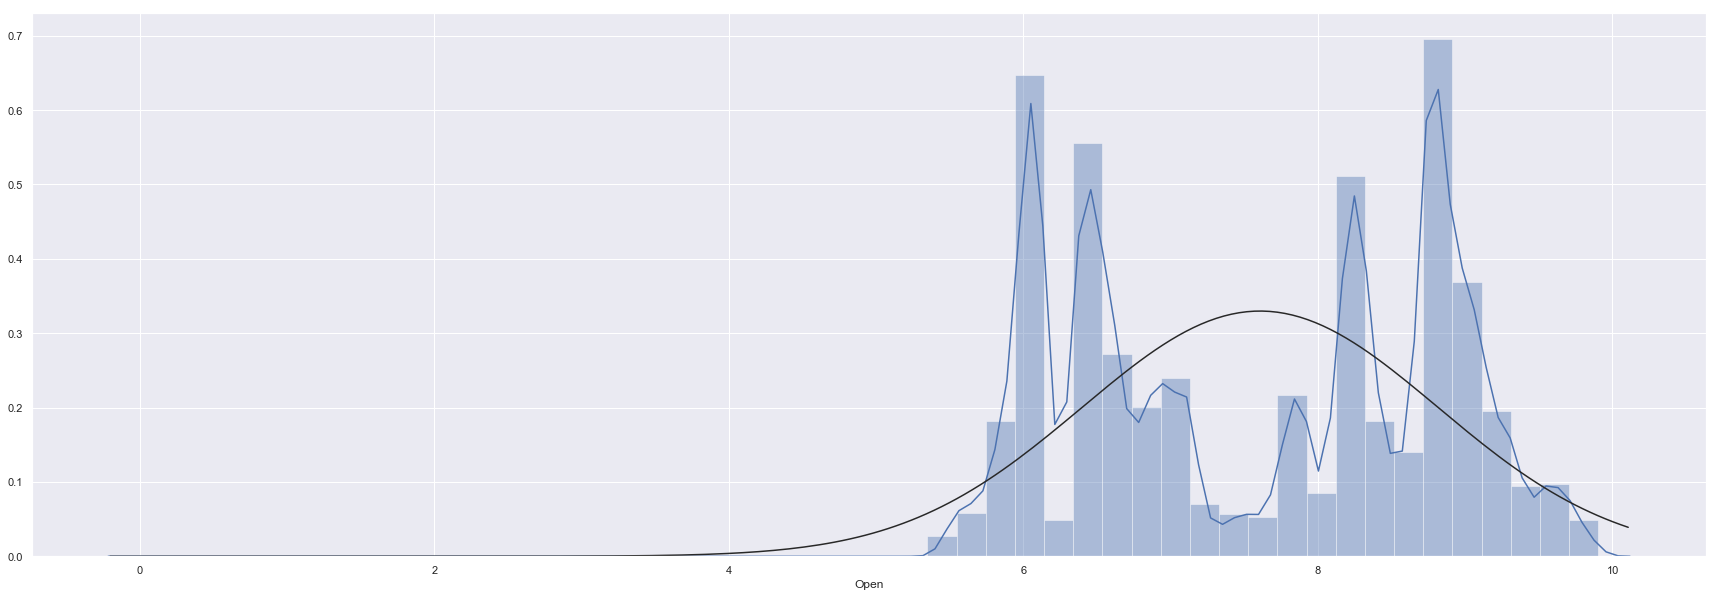

In [27]:
sns.distplot(BTC_price['Open'], fit=stats.norm)

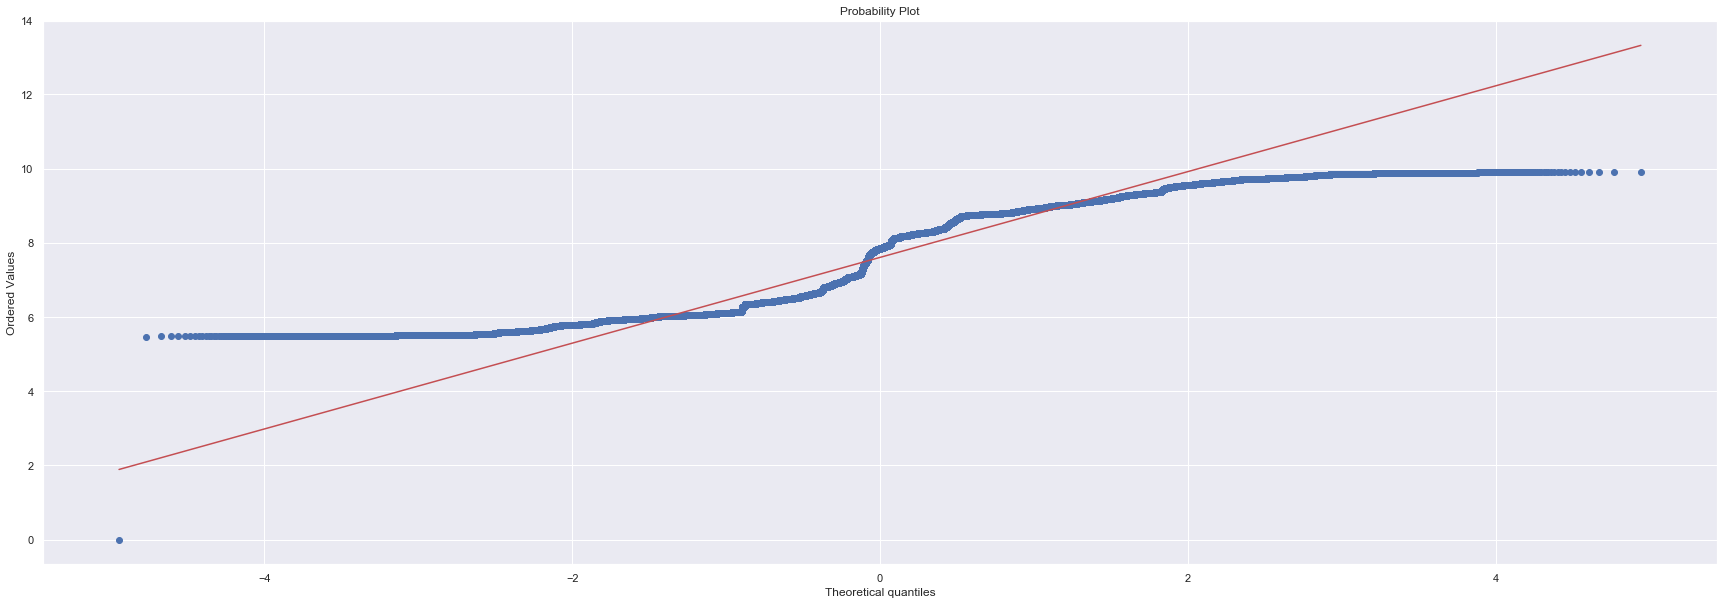

In [28]:
 res = stats.probplot(BTC_price['Open'], plot=plt)
plt.show()